In [873]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
import torchvision.models as models

import copy, os, time, sys, h5py, pickle, argparse, json
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from tqdm import tqdm
import pandas as pd

In [733]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def get_model(layer_name = 'pool4'):
    cnn = models.vgg19(pretrained=True).features.to(device).eval()
    
    i=j=1
    model = nn.Sequential()
    layer_names = []
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            name = 'conv{}_{}'.format(i, j)
            j+=1
        elif isinstance(layer, nn.ReLU):
            name = 'relu{}_{}'.format(i, j)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool{}'.format(i)
            i+=1; j=1;
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        model.add_module(name, layer)
        if name == layer_name:
            break
    return model

def load_fit_weights(layer, area, ver='V6'):
    ROOTDIR = '/home/gru/akshay/neurint'
    if area == 'V1':
        filepath = f'{ROOTDIR}/model_fits/{area}_vgg19_{layer}-fit_5-components.pickle'
    else:
        filepath = f'{ROOTDIR}/model_fits/{area}_vgg19_{layer}-fit_5-components_{ver}.pickle'
    print(filepath)
    if os.path.isfile(filepath):
        results = np.load(filepath, allow_pickle=True)
        weights = np.array(results[f'{area.lower()}_weights']).squeeze()
        return weights
    else:
        print(f'Weight file not found : {filepath}')
        return None

def rgb_from_grey(grey):
    wide, high = grey.size
    rgb = np.empty((wide, high, 3), dtype=np.uint8)
    rgb[:, :, 2] =  rgb[:, :, 1] =  rgb[:, :, 0] =  grey
    return rgb


def image_loader(image_name):
    imsize = 256 if torch.cuda.is_available() else 128  # use small size if no gpu

    loader = transforms.Compose([
            transforms.Resize(imsize),  # scale imported image
            transforms.CenterCrop(imsize),
            transforms.ToTensor()])  # transform it into a torch tensor

    image = Image.open(image_name).convert('RGB')
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


def rgb_from_grey(grey):
    wide, high = grey.shape
    rgb = np.empty((wide, high, 3), dtype=np.uint8)
    rgb[:, :, 2] =  rgb[:, :, 1] =  rgb[:, :, 0] =  grey
    return rgb

def image_loader_from_array(input_image):
    imsize = 256 if torch.cuda.is_available() else 128  # use small size if no gpu
    image = rgb_from_grey(input_image)
    loader = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize(imsize),  # scale imported image
                                 transforms.ToTensor()])  # transform it into a torch tensor
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def get_neural_model_response(images, layer, area, loader = image_loader):
    model = get_model(layer)
    W = torch.from_numpy(load_fit_weights(layer, area).T).to(device)

    neural_responses = []
    for i_image in tqdm(range(len(images)), desc='Extracting model responses'): 
        input_image = loader(images[i_image])
        resp = model(input_image).detach()
        model_response = resp.view(resp.shape[0], -1).detach()
        neural_response = torch.matmul(model_response.float(), W.float()).detach().cpu().numpy()
        neural_responses.append(neural_response.flatten())
    return np.array(neural_responses)

def get_all_neural_response():
    image_path = 'outputs/stimuli/{}_{}_{}_s{}.png'
    image_pairs = ['elephant1_face1', 'rocks_leaves', 'horse_cat', 'grating0_grating90']
    intervals = ['0','25','50','75','100']
    feat_spaces = ['pool3-V1', 'pool4-IT']
    samples = [1,2,3]
    #image_list = [image_path.format(image_pair, interval, '{}', '{}') for image_pair in image_pairs for interval in intervals]
    images = [image_path.format(image_pair, interval, feat_space, sample) for feat_space in feat_spaces for image_pair in image_pairs 
                                                                          for interval in intervals for sample in samples]
    neural_response = {'params': {'image_path': image_path, 'image_pairs': image_pairs, 'intervals': intervals, 
                                  'feat_spaces': feat_spaces, 'images': images, 'samples': samples}}
    
    neural_response['image_pairs'] = np.array([image_pairs.index(image_pair) for _ in feat_spaces  for image_pair in image_pairs 
                                                                             for _ in intervals for _ in samples])
    neural_response['image_interval'] = np.array([intervals.index(interval) for _ in feat_spaces  for _ in image_pairs 
                                                                            for interval in intervals for _ in samples])
    neural_response['image_feat_space'] = np.array([feat_spaces.index(feat_space) for feat_space in feat_spaces for _ in image_pairs  
                                                                                  for _ in intervals for _ in samples])
    neural_response['image_sample'] = np.array([samples.index(sample) for _ in feat_spaces for _ in image_pairs  
                                                                      for _ in intervals for sample in samples])
    neural_response['IT_data'] = get_neural_model_response(images, 'pool4', 'IT')
    neural_response['V1_data'] = get_neural_model_response(images, 'pool3', 'V1')
    
    return neural_response


cuda


In [387]:
image_path = 'outputs/color/{}_{}_{}_s{}.png'
image_pairs = ['elephant1_face1', 'rocks_leaves', 'horse_cat', 'grating0_grating90']
intervals = ['0','25','50','75','100']
layers = ['pool3-V1', 'pool4-IT']
image_list = [image_path.format(image_pair, interval, '{}', '{}') for image_pair in image_pairs for interval in intervals]


# IT-linear images are in fact linearly interpolating through model IT space

In [380]:
# Sample 1 
images = [imagename.format('pool4-IT', 1) for imagename in image_list]
IT_responses = get_neural_model_response(images, 'pool4', 'IT')
pca = PCA(n_components=2)
X1 = pca.fit_transform(IT_responses)

# Sample 2
images = [imagename.format('pool4-IT', 2) for imagename in image_list]
IT_responses = get_neural_model_response(images, 'pool4', 'IT')
#pca = PCA(n_components=2)
X2 = pca.fit_transform(IT_responses)

Extracting model responses: 100%|██████████| 10/10 [00:00<00:00, 132.37it/s]

/home/gru/akshay/neurint/model_fits/IT_vgg19_pool4-fit_5-components_V6.pickle



Extracting model responses: 100%|██████████| 10/10 [00:00<00:00, 134.76it/s]

/home/gru/akshay/neurint/model_fits/IT_vgg19_pool4-fit_5-components_V6.pickle


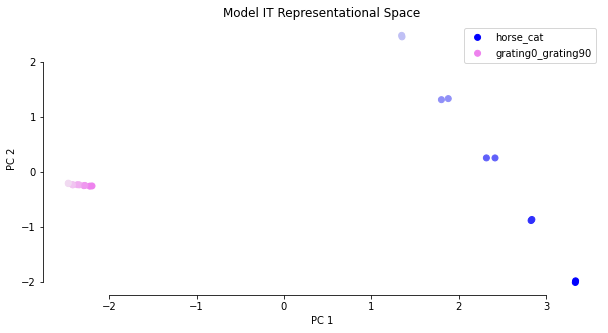

In [381]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,5))

palnames = ['blue', 'violet', 'magenta', 'lime']
labels = []
for pi, image_pair in enumerate(image_pairs):
    colors = sns.light_palette(palnames[pi])[::-1]
    k = pi*5
    ax.scatter(X1[(pi*5):(pi*5)+5,0], X1[(pi*5):(pi*5)+5,1], color=list(colors)[:len(intervals)])
    labels.append(image_pair)

for pi, palette in enumerate(image_pairs):
    colors = sns.light_palette(palnames[pi])[::-1]
    k = pi*5
    ax.scatter(X2[(pi*5):(pi*5)+5,0], X2[(pi*5):(pi*5)+5,1], color=list(colors)[:len(intervals)])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('Model IT Representational Space')
ax.legend(labels)

sns.despine(trim=True)

# However, IT-linear images are not linear in model V1 space

In [388]:
images = [imagename.format('pool4-IT', 1) for imagename in image_list]

IT_responses = get_neural_model_response(images, 'pool3', 'V1')
pca = PCA(n_components=2)
X1 = pca.fit_transform(IT_responses)

Extracting model responses:   0%|          | 0/20 [00:00<?, ?it/s]

/home/gru/akshay/neurint/model_fits/V1_vgg19_pool3-fit_5-components.pickle


Extracting model responses: 100%|██████████| 20/20 [00:00<00:00, 150.02it/s]


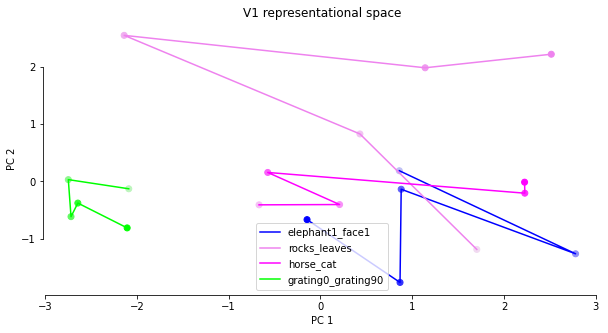

In [389]:
fig, ax = plt.subplots(figsize=(10,5))
palnames = ['blue', 'violet', 'magenta', 'lime']
labels = []
for pi, image_pair in enumerate(image_pairs):
    colors = sns.light_palette(palnames[pi])[::-1]
    k = pi*5
    ax.scatter(X1[(pi*5):(pi*5)+5,0], X1[(pi*5):(pi*5)+5,1], color=list(colors)[:5])
    ax.plot(X1[(pi*5):(pi*5)+5,0], X1[(pi*5):(pi*5)+5,1], color=list(colors)[0])
    labels.append(image_pair)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('V1 representational space')
ax.legend(labels)


sns.despine(trim=True)

# Are V1-linear images actually linearly interpolating through model V1 space?

In [392]:
images = [imagename.format('pool3-V1', 1) for imagename in image_list]


IT_responses = get_neural_model_response(images, 'pool3', 'V1')
pca = PCA(n_components=2)
X1 = pca.fit_transform(IT_responses)

Extracting model responses:   0%|          | 0/20 [00:00<?, ?it/s]

/home/gru/akshay/neurint/model_fits/V1_vgg19_pool3-fit_5-components.pickle


Extracting model responses: 100%|██████████| 20/20 [00:00<00:00, 145.50it/s]


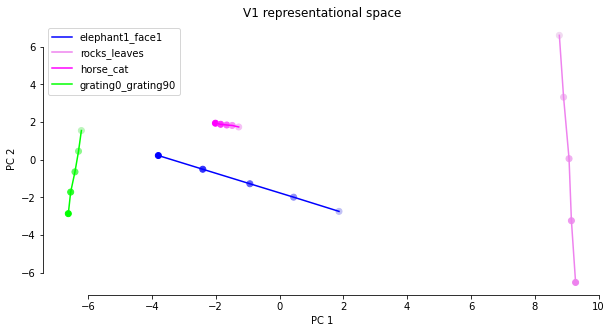

In [393]:

fig, ax = plt.subplots(figsize=(10,5))
palnames = ['blue', 'violet', 'magenta', 'lime']
labels = []
for pi, image_pair in enumerate(image_pairs):
    colors = sns.light_palette(palnames[pi])[::-1]
    k = pi*5
    ax.scatter(X1[(pi*5):(pi*5)+5,0], X1[(pi*5):(pi*5)+5,1], color=list(colors)[:5])
    ax.plot(X1[(pi*5):(pi*5)+5,0], X1[(pi*5):(pi*5)+5,1], color=list(colors)[0])
    labels.append(image_pair)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('V1 representational space')
ax.legend(labels)
sns.despine(trim=True)

# Are V1-linear images linear in model IT space?

In [396]:
images = [imagename.format('pool3-V1', 1) for imagename in image_list]

IT_responses = get_neural_model_response(images, 'pool4', 'IT')
pca = PCA(n_components=2)
X1 = pca.fit_transform(IT_responses)

Extracting model responses:  65%|██████▌   | 13/20 [00:00<00:00, 126.90it/s]

/home/gru/akshay/neurint/model_fits/IT_vgg19_pool4-fit_5-components_V6.pickle


Extracting model responses: 100%|██████████| 20/20 [00:00<00:00, 128.51it/s]


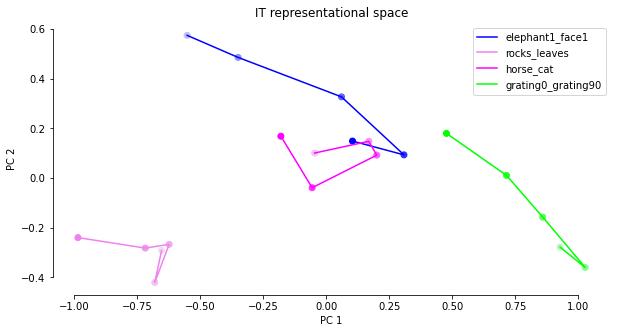

In [398]:
fig, ax = plt.subplots(figsize=(10,5))
palnames = ['blue', 'violet', 'magenta', 'lime']
labels = []
for pi, image_pair in enumerate(image_pairs):
    colors = sns.light_palette(palnames[pi])[::-1]
    k = pi*5
    ax.scatter(X1[(pi*5):(pi*5)+5,0], X1[(pi*5):(pi*5)+5,1], color=list(colors)[:5])
    ax.plot(X1[(pi*5):(pi*5)+5,0], X1[(pi*5):(pi*5)+5,1], color=list(colors)[0])
    labels.append(image_pair)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('IT representational space')
ax.legend(labels)

sns.despine(trim=True)

# Test on sinusoidal stimuli

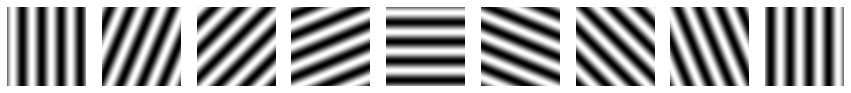

In [332]:
def genSinusoid(theta, omega, sz=(256,256), A=1, K=np.pi):
    # Generate Sinusoid grating
    # sz: size of generated image (width, height)
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1)) # a BUG is fixed in this line
    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)
    stimuli = np.sin(omega * x1) * np.exp(K**2 / 2)
    
    stimuli = (stimuli - np.min(stimuli)) / (np.max(stimuli) - np.min(stimuli))
    stimuli = np.moveaxis(np.stack((stimuli,)*3), 0,2)
    return stimuli


#theta = np.pi/4
omega = 0.1 #[np.cos(theta), np.sin(theta)]
thetas = np.linspace(0, np.pi, 9)


fig,axes = plt.subplots(1,9,figsize=(15,5))
for ti, theta in enumerate(thetas):
    axes[ti].imshow(genSinusoid(theta, omega)) 
    axes[ti].axis('off')


In [334]:
thetas = np.linspace(0, np.pi, 9)

for ti, theta in enumerate(thetas):
    print(theta, 180*theta/np.pi)

0.0 0.0
0.39269908169872414 22.5
0.7853981633974483 45.0
1.1780972450961724 67.5
1.5707963267948966 90.0
1.9634954084936207 112.5
2.356194490192345 135.0
2.748893571891069 157.5
3.141592653589793 180.0


In [342]:
thetas = np.linspace(0, np.pi, 9)
for ti, theta in enumerate(thetas):
    sinusoid = genSinusoid(theta, omega)
    plt.imsave(f'/home/gru/akshay/textures/input/grating{int(180*theta/np.pi)}.jpg', sinusoid)


In [283]:
omega = 0.1 #[np.cos(theta), np.sin(theta)]
thetas = np.linspace(0, np.pi/2, 9)
images = []
for theta in thetas:
    #theta = np.pi/4
    sinusoid = genSinusoid(theta, omega)
    images.append(sinusoid)

neural_responses = get_neural_model_response(images, 'pool4', 'IT', loader=image_loader_from_array)
pca = PCA(n_components=2)
X1 = pca.fit_transform(neural_responses)
#X1 = pca.transform(IT_responses)



Extracting model responses: 100%|██████████| 9/9 [00:00<00:00, 143.96it/s]

/home/gru/akshay/neurint/model_fits/IT_vgg19_pool4-fit_5-components_V6.pickle


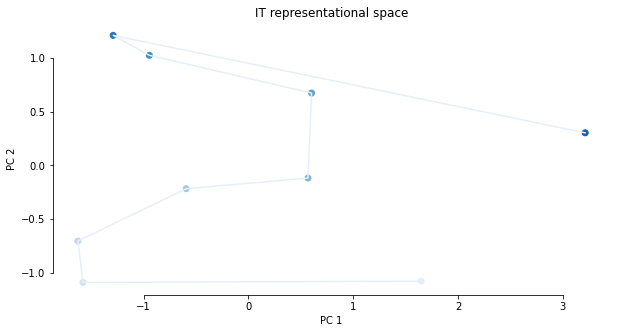

In [284]:
fig, ax = plt.subplots(figsize=(10,5))

#for pi, palette in enumerate(['Blues', 'Greens', 'Reds']):
colors = sns.color_palette('Blues', 10)
k = pi*5
ax.scatter(X1[:,0], X1[:,1], color=list(colors)[:X1.shape[0]])
ax.plot(X1[:,0], X1[:,1], color=list(colors)[0])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('IT representational space')
sns.despine(trim=True)

# Test on rotated face stimuli

In [ ]:
image_list = [f'outputs/rotated_faces/f{i+1}_r{j+1}.pgm' for i in np.arange(1) for j in np.arange(21)]

for img in image_list:
    x = rgb_from_grey(plt.imread(img))
    new_name = img.split('.')[0]+'.jpg'
    plt.imsave(new_name, x)

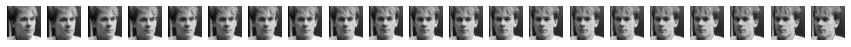

In [271]:
image_list = [f'outputs/rotated_faces/f{i+1}_r{j+1}.jpg' for i in np.arange(1) for j in np.arange(21)]

fig,axes = plt.subplots(1, len(image_list), figsize=(15,5))
for i,img in enumerate(image_list):
    image = Image.open(img)
    axes[i].imshow(image)
    axes[i].axis('off')

In [274]:
image_list = [f'outputs/rotated_faces/f{i+1}_r{j+1}.jpg' for i in np.arange(1) for j in np.arange(21)]

IT_responses = get_neural_model_response(image_list, 'pool4', 'IT')
pca = PCA(n_components=2)
X1 = pca.fit_transform(IT_responses)

Extracting model responses:  76%|███████▌  | 16/21 [00:00<00:00, 154.73it/s]

/home/gru/akshay/neurint/model_fits/IT_vgg19_pool4-fit_5-components_V6.pickle


Extracting model responses: 100%|██████████| 21/21 [00:00<00:00, 155.27it/s]


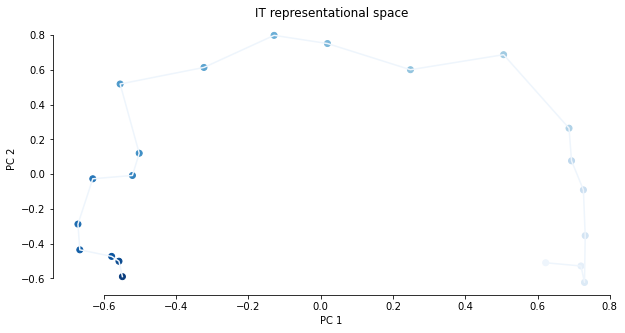

In [276]:
fig, ax = plt.subplots(figsize=(10,5))

#for pi, palette in enumerate(['Blues', 'Greens', 'Reds']):
colors = sns.color_palette('Blues', X1.shape[0])
k = pi*5
ax.scatter(X1[:,0], X1[:,1], color=list(colors)[:X1.shape[0]])
ax.plot(X1[:,0], X1[:,1], color=list(colors)[0])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('IT representational space')
sns.despine(trim=True)

# Use neural responses to model behavior

In [734]:
neural_data = get_all_neural_response()

Extracting model responses:  12%|█▎        | 15/120 [00:00<00:00, 148.83it/s]

/home/gru/akshay/neurint/model_fits/IT_vgg19_pool4-fit_5-components_V6.pickle


Extracting model responses:   0%|          | 0/120 [00:00<?, ?it/s]

/home/gru/akshay/neurint/model_fits/V1_vgg19_pool3-fit_5-components.pickle


Extracting model responses: 100%|██████████| 120/120 [00:00<00:00, 190.73it/s]


In [727]:
def plot_dist_matrix(neural_data, area='IT'):
    IT_responses = neural_data[f'{area}_data']
    dist = lambda x,y: 1-np.corrcoef(x,y)[0,1]
    dist_matrix = np.zeros((IT_responses.shape[0], IT_responses.shape[0]))
    for i in range(IT_responses.shape[0]):
        for j in range(IT_responses.shape[0]):
            dist_matrix[i,j] = dist(IT_responses[i,:], IT_responses[j,:])#IT_responses[59,:])#IT_responses[j,:])

    image_filenames = neural_data['params']['images']
    image_labels = []
    for fi, feat_space in enumerate(neural_data['params']['feat_spaces']):
        for pi, image_pair in enumerate(neural_data['params']['image_pairs']):
            for ii, interval in enumerate(neural_data['params']['intervals']):
                for si, sample in enumerate(neural_data['params']['samples']):
                    image_str = ''
                    if pi == 0 and ii == 0 and si == 0: image_str += '•' + feat_space
                    if ii == 0 and si == 0: image_str += ' • ' + image_pair
                    if si == 0: image_str += ' • ' + interval
                    image_str += '  ' + '-'*(1+si) + ' '*(2-si)
                    image_labels.append(image_str)
    fig, ax = plt.subplots(figsize=(10,7))
    sns.heatmap(dist_matrix,yticklabels=image_labels, xticklabels=image_labels)

#plot_dist_matrix(neural_data, area='IT')
#plot_dist_matrix(neural_data, area='V1')

In [728]:
def simulate_trials(neural_data, num_trials = 1000):
    p = neural_data['params']
    df = pd.DataFrame()
    df['image_pair'] = np.random.choice(p['image_pairs'], size=(num_trials,))
    df['feat_space'] = np.random.choice(p['feat_spaces'], size=(num_trials,))
    df['interval'] = np.random.choice(p['intervals'], size=(num_trials,))
    df['target_sample'] = np.random.choice(p['samples'], size=(num_trials,))
    choice0_sample, choice100_sample = [], []
    for i in range(num_trials):
        if df['interval'].loc[i] == '0':
            choice0_sample.append(np.random.choice(np.setdiff1d(p['samples'], df['target_sample'].loc[i])))
        else:
            choice0_sample.append(np.random.choice(p['samples']))
        if df['interval'].loc[i] == '100':
            choice100_sample.append(np.random.choice(np.setdiff1d(p['samples'], df['target_sample'].loc[i])))
        else:
            choice100_sample.append(np.random.choice(p['samples']))
    df['choice0_sample'] = choice0_sample
    df['choice1_sample'] = choice100_sample
    return df

In [747]:
def softmax(X, beta=2):
    return np.exp(beta*np.array(X)) / np.sum(np.exp(beta*np.array(X)))

def estimate_neural_performance(neural_data, trials, area = 'IT'):
    neural = neural_data[f'{area}_data']
    df = trials.copy()
    dist = lambda x,y: 1-np.corrcoef(x,y)[0,1]
    choice1_probability = []
    for i in range(len(df)):
        target_index = np.where(np.logical_and.reduce((neural_data['image_feat_space']==neural_data['params']['feat_spaces'].index(df.feat_space[i]),
                                                 neural_data['image_pairs']==neural_data['params']['image_pairs'].index(df.image_pair[i]),
                                                 neural_data['image_interval']==neural_data['params']['intervals'].index(df.interval[i]),
                                                 neural_data['image_sample']==neural_data['params']['samples'].index(df.target_sample[i]))))[0][0]
        
        choice0_index = np.where(np.logical_and.reduce((neural_data['image_feat_space']==neural_data['params']['feat_spaces'].index(df.feat_space[i]),
                                                 neural_data['image_pairs']==neural_data['params']['image_pairs'].index(df.image_pair[i]),
                                                 neural_data['image_interval']==0,
                                                 neural_data['image_sample']==neural_data['params']['samples'].index(df.choice0_sample[i]))))[0][0]
        choice1_index = np.where(np.logical_and.reduce((neural_data['image_feat_space']==neural_data['params']['feat_spaces'].index(df.feat_space[i]),
                                                 neural_data['image_pairs']==neural_data['params']['image_pairs'].index(df.image_pair[i]),
                                                 neural_data['image_interval']==len(neural_data['params']['intervals'])-1,
                                                 neural_data['image_sample']==neural_data['params']['samples'].index(df.choice1_sample[i]))))[0][0]
        target_response = neural[target_index,:]
        choice0_response = neural[choice0_index,:]
        choice1_response = neural[choice1_index,:]
        choice_probabilities = softmax([1-dist(target_response, choice0_response), 
                                        1-dist(target_response, choice1_response)])
        choice1_probability.append(choice_probabilities[1])
    df['choice1_probability'] = choice1_probability
    return df


In [750]:
def plot_observermodel_response(neural_data, trials, hue='image_pair'):
    if hue == 'image_pair':
        hue_order = neural_data['params']['image_pairs']
    else:
        hue_order = neural_data['params']['feat_spaces']
    fig,axes = plt.subplots(1,2,figsize=(16,5))

    palettes = ['Blues', 'Purples']
    areas = ['V1', 'IT']
    for ai, area in enumerate(areas):
        df = estimate_neural_performance(neural_data, trials, area = area)
        if hue == 'feat_space':
            sns.pointplot(data = df, x = 'interval', y = 'choice1_probability', hue = 'feat_space', 
                      hue_order=hue_order, order = ['0', '25', '50', '75', '100'], 
                      ax=axes[ai], palette = [sns.color_palette('Blues_r')[0], sns.color_palette('Purples_r')[0]])
        else:
            for fi, feat_space in enumerate(neural_data['params']['feat_spaces']):
                df_i = df.loc[df['feat_space']==feat_space].reset_index(drop=True)
                sns.pointplot(data = df_i, x = 'interval', y = 'choice1_probability', hue = hue, 
                              hue_order=hue_order, order = ['0', '25', '50', '75', '100'], 
                              ax=axes[ai], palette = palettes[fi])
        axes[ai].set_title(f'{area} ideal observer')
        axes[ai].set_ylim(.2, .8)
        axes[ai].legend(frameon=False)
        sns.despine(trim=True)


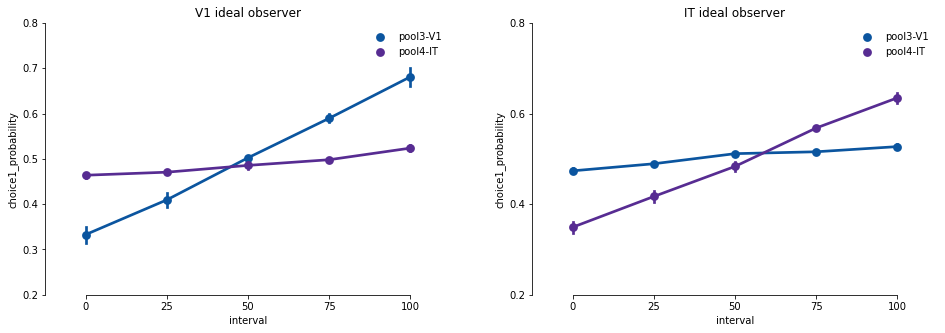

In [751]:
trials = simulate_trials(neural_data, 1000)
plot_observermodel_response(neural_data, trials, hue='feat_space')


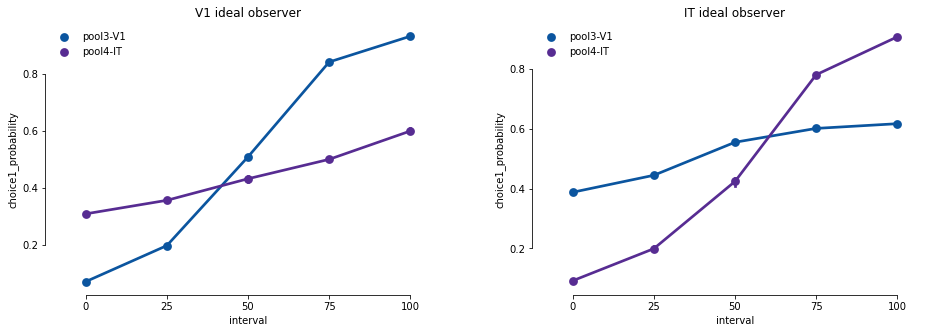

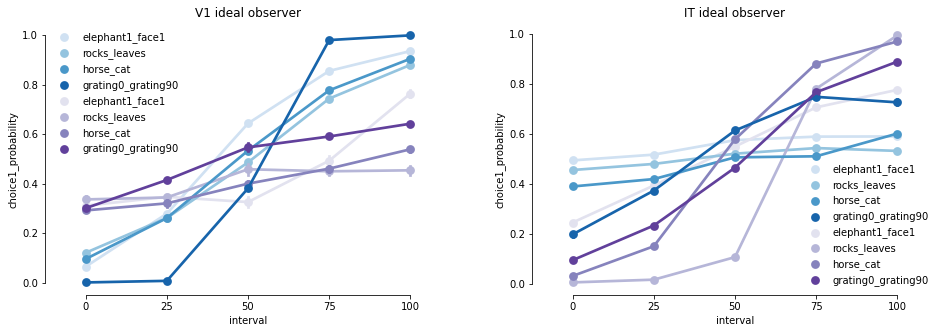

In [745]:
plot_observermodel_response(neural_data, trials, hue='feat_space')
plot_observermodel_response(neural_data, trials, hue='image_pair')

# Compare to human behavior

In [783]:
def load_behavioral_data(datadir, accuracy_cutoff=0.6, concurrent=False):
    if concurrent:
        response_seg = 1;
    else:
        response_seg = 3
    df = pd.DataFrame(columns=['subject', 'correct', 'choice', 'image_pair', 'feature_space', 'left_interval', 'right_interval', 'left_sample', 'right_sample', 'center_sample', 'center_interval', 'response', 'RT'])

    feature_spaces = ['pool3-V1', 'pool4-IT']
    image_pairs = ['elephant1_face1', 'horse_cat', 'rocks_leaves', 'grating0_grating90']
    lr_intervals = [0, 100]
    taskkeys = np.array([121,103,106])
    for subj_dir in os.listdir(datadir):
        if 'old' in subj_dir or 'undefined' in subj_dir or '.DS_Store' in subj_dir:
            continue
        rows = []
        acc = []
        subj_files = os.listdir('{}/{}'.format(datadir, subj_dir))
        for subj_file in subj_files:
            with open('{}/{}/{}'.format(datadir, subj_dir, subj_file), 'r') as json_file:
                data = json.load(json_file)
                if 'correct' in data:
                    accuracy = np.nanmean(np.array(data['correct'], dtype=float))
                    acc.extend(data['correct'])
                    nTrials = np.sum(np.logical_not(np.isnan(np.array(data['correct'], dtype=float))))
                    if nTrials < 10:
                        # Run ended prematurely
                        continue
                    #if accuracy < accuracy_cutoff:
                        # Accuracy failed to reach cutoff - exclude!
                    #    continue
                    rows.extend([pd.Series([subj_dir, data['correct'][i], data['img_choice'][i], image_pairs[data['image_pair'][i]-1], feature_spaces[data['feature_space'][i]-1], 
                                       lr_intervals[data['left_img'][i]-1], lr_intervals[data['right_img'][i]-1], data['left_sample'][i], data['right_sample'][i], 
                                       data['center_sample'][i], data['center_interval'][i], data['response'][i][response_seg], data['RT'][i][response_seg]], index = df.columns) for i in range(len(data['key']))])
        acc = np.array(acc)
        acc = np.nanmean(acc[acc!=None].astype(int))
        #print(subj_dir, acc)
        if acc > accuracy_cutoff:
            df = df.append(rows, ignore_index=True)
    # exclude all nans
    df = df.dropna().reset_index(drop=True)
    #df = df[np.logical_not(np.isnan(df['choice']))].reset_index(drop=True)
    df['choice'] = df['choice']-1

    print('Found {} trials across {} subjects'.format(df.shape[0], len(np.unique(df['subject']))))
    trial_params = {'image_pairs': image_pairs, 'feature_spaces': feature_spaces}#{'image_pairs': ['elephant1_face1', 'rocks_leaves'], 'layer': ['pool1', 'pool2', 'pool4'], 'poolsize': ['1x1', '2x2', '3x3', '4x4'], 'sample': [1, 2]}
    
    results = {'data_table': df, 'trial_params': trial_params}
    
    return results


In [784]:
behavior = load_behavioral_data('/home/gru/akshay/neurint/behavioral_data')
behavior_con = load_behavioral_data('/home/gru/akshay/neurint/behavioral_data_con', concurrent=True)

/home/gru/anaconda3/envs/akshay3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gru/anaconda3/envs/akshay3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-783-4afe5e3f222c>:22: RuntimeWarning: Mean of empty slice
  accuracy = np.nanmean(np.array(data['correct'], dtype=float))


Found 1342 trials across 15 subjects


<ipython-input-783-4afe5e3f222c>:22: RuntimeWarning: Mean of empty slice
  accuracy = np.nanmean(np.array(data['correct'], dtype=float))
/home/gru/anaconda3/envs/akshay3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gru/anaconda3/envs/akshay3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Found 1402 trials across 16 subjects


In [919]:
def softmax(X, beta=2, axis=0):
    return np.exp(beta*np.array(X)) / np.expand_dims(np.sum(np.exp(beta*np.array(X)), axis=axis), axis=axis)

def get_model_distances(neural_data, behavior, area = 'IT'):
    #trials = behavior['data_table']
    neural = neural_data[f'{area}_data']
    df = behavior['data_table'].copy()
    dist = lambda x,y: 1-np.corrcoef(x,y)[0,1]
    choice1_probability = []
    distances = []
    for i in range(len(df)):
        target_index = np.where(np.logical_and.reduce((neural_data['image_feat_space']==neural_data['params']['feat_spaces'].index(df.feature_space[i]),
                                                 neural_data['image_pairs']==neural_data['params']['image_pairs'].index(df.image_pair[i]),
                                                 neural_data['image_interval']==neural_data['params']['intervals'].index(str(df.center_interval[i])),
                                                 neural_data['image_sample']==neural_data['params']['samples'].index(df.center_sample[i]))))[0][0]
        
        if df.left_interval[i] == 0:
            sample0 = df.left_sample[i]
            sample1 = df.right_sample[i]
        else:
            sample0 = df.right_sample[i]
            sample1 = df.left_sample[i]
            
        choice0_index = np.where(np.logical_and.reduce((neural_data['image_feat_space']==neural_data['params']['feat_spaces'].index(df.feature_space[i]),
                                                 neural_data['image_pairs']==neural_data['params']['image_pairs'].index(df.image_pair[i]),
                                                 neural_data['image_interval']==0,
                                                 neural_data['image_sample']==neural_data['params']['samples'].index(sample0))))[0][0]

        choice1_index = np.where(np.logical_and.reduce((neural_data['image_feat_space']==neural_data['params']['feat_spaces'].index(df.feature_space[i]),
                                                 neural_data['image_pairs']==neural_data['params']['image_pairs'].index(df.image_pair[i]),
                                                 neural_data['image_interval']==len(neural_data['params']['intervals'])-1,
                                                 neural_data['image_sample']==neural_data['params']['samples'].index(sample1))))[0][0]
        target_response = neural[target_index,:]
        choice0_response, choice1_response = neural[choice0_index,:], neural[choice1_index,:]
        distances.append([1-dist(target_response, choice0_response), 1-dist(target_response, choice1_response)])
    return np.array(distances)

def generate_shuffle(n, ratio=0.75):
    sh = np.random.permutation(range( n ))
    return sh[:int(len(sh)*(ratio))], sh[int(len(sh)*(ratio)):]

def fixed_readout_model(distances, behavior, train_, test_):
    df = behavior['data_table'].copy()
    choice = np.array(df.choice)
    
    def minfunc(parameters, distances, choice, get_prob=False):
        sm = softmax(distances, beta=parameters[0], axis=1)
        subj_choice_prob = [sm[i, int(choice[i])] for i in range(len(choice))]
        log_loss = -np.nanmean(np.log(subj_choice_prob))
        if get_prob:
            return log_loss, sm[:,1]
        return log_loss
    
    init_params = [25]
    results = minimize(minfunc, init_params, args=(distances[train_], choice[train_]))
    log_loss, model_prob = minfunc(results.x, distances[test_], choice[test_], get_prob=True)
    return results.x[0], log_loss, model_prob

def weighted_readout_model(IT_distances, V1_distances, behavior, train_, test_):
    df = behavior['data_table'].copy()
    choice = np.array(df.choice)
    
    def minfunc(parameters, IT_distances, V1_distances, choice, get_prob=False):
        distances = IT_distances*parameters[0] + V1_distances*parameters[1]
        sm = softmax(distances, beta=parameters[2], axis=1)
        subj_choice_prob = [sm[i, int(choice[i])] for i in range(len(choice))]
        log_loss = -np.nanmean(np.log(subj_choice_prob))
        if get_prob:
            return log_loss, sm[:,1]
        return log_loss
    init_params = [0.5, 0.5, 5]
    results = minimize(minfunc, init_params, args=(IT_distances[train_], V1_distances[train_], choice[train_]))
    log_loss, model_prob = minfunc(results.x, IT_distances[test_], V1_distances[test_], choice[test_], get_prob=True)
    return results.x, log_loss, model_prob

def switching_observer_model(IT_distances, V1_distances, behavior, train_, test_):
    df = behavior['data_table'].copy()
    choice = np.array(df.choice)

    def minfunc(parameters, IT_distances, V1_distances, choice, get_prob=False):
        IT_probability = softmax(IT_distances, beta = parameters[0], axis=1)
        V1_probability = softmax(V1_distances, beta = parameters[1], axis=1)
        subj_choice_prob = []
        for i in range(IT_probability.shape[0]):
            it = IT_probability[i,:]
            v1 = V1_probability[i,:]
            if np.diff(it)[0] > np.diff(v1)[0]:
                subj_choice_prob.append(it[int(choice[i])])
            else:
                subj_choice_prob.append(v1[int(choice[i])])
        log_loss = -np.nanmean(np.log(subj_choice_prob))
        if get_prob:
            return log_loss, None
        else:
            return log_loss  
    init_params = [5,5]
    results = minimize(minfunc, init_params, args=(IT_distances[train_], V1_distances[train_], choice[train_]))
    log_loss = minfunc(results.x, IT_distances[test_], V1_distances[test_], choice[test_])
    return results.x, log_loss, None

# Get model distances for IT and V1 models
IT_distances = get_model_distances(neural_data, behavior_con, 'IT')
V1_distances = get_model_distances(neural_data, behavior_con, 'V1')
# Generate train and test splits
train_, test_ = generate_shuffle(len(behavior_con['data_table']), 0.5)
# Compute model predictions against behavior for all different observer models
it_beta, it_loss, it_prob = fixed_readout_model(IT_distances, behavior_con, train_, test_)
v1_beta, v1_loss, v1_prob = fixed_readout_model(V1_distances, behavior_con, train_, test_)
weights, weighted_loss, weighted_prob = weighted_readout_model(IT_distances, V1_distances, behavior_con, train_, test_)
betas, switch_loss, switch_prob = switching_observer_model(IT_distances, V1_distances, behavior_con, train_, test_)

print(f'IT observer: beta={it_beta:.3f}; likelihood={np.exp(-it_loss):.4f}')
print(f'V1 observer: beta={v1_beta:.3f}; likelihood={np.exp(-v1_loss):.4f}')
print(f'Weighted observer: IT weight = {weights[0]:.3f}; V1 weight = {weights[1]:.3f}; beta = {weights[2]:.3f}; likelihood={np.exp(-weighted_loss):.4f}')
print(f'Switching observer: IT beta={betas[0]:.3f}, V1 beta={betas[1]:.3f}, likelihood={np.exp(-switch_loss):.4f}')

IT observer: beta=3.040; likelihood=0.5263
V1 observer: beta=2.423; likelihood=0.5229
Weighted observer: IT weight = 0.461; V1 weight = 0.374; beta = 4.984; likelihood=0.5384
Switching observer: IT beta=2.476, V1 beta=2.526, likelihood=0.5209


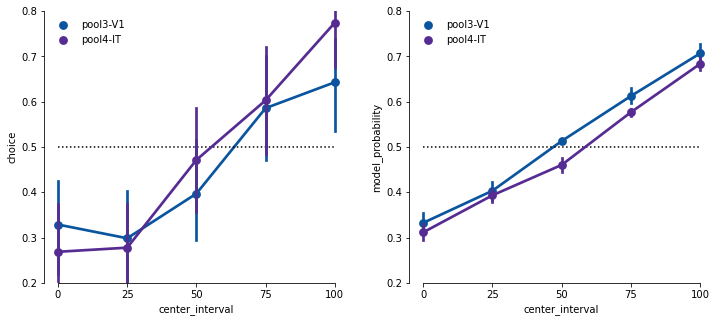

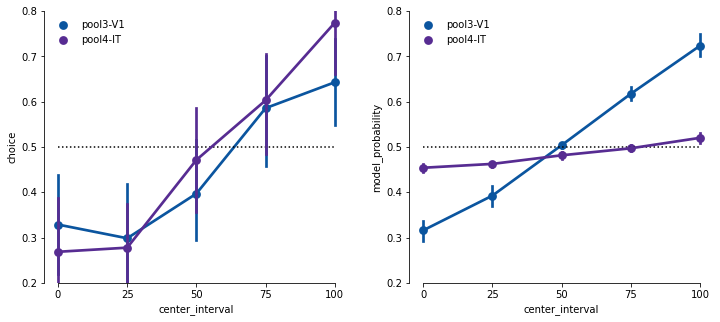

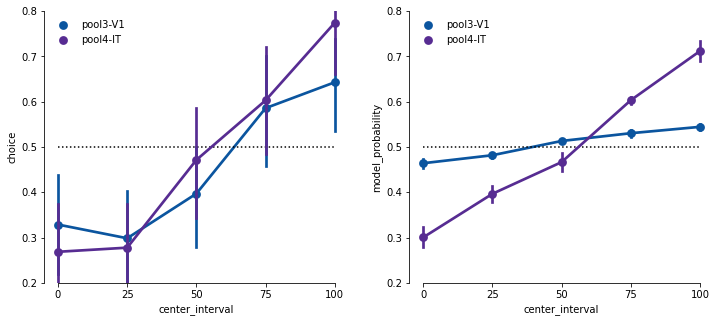

In [920]:
def plot_behavior_response(behavior, hue='image_pair',df=None):
    if hue == 'image_pair':
        hue_order = behavior['trial_params']['image_pairs']
    else:
        hue_order = behavior['trial_params']['feature_spaces']

    palettes = ['Blues', 'Purples']
    if df is None:
        df = behavior['data_table']
    #df = df.loc[df['image_pair']!='grating0_grating90']
    if hue == 'feature_space':
        fig,axes = plt.subplots(1,2,figsize=(12,5))
        for yi, y_axis in enumerate(['choice', 'model_probability']):
            ax = axes[yi]
            sns.pointplot(data = df, x = 'center_interval', y = y_axis, hue = 'feature_space', 
                      hue_order=hue_order, ax=ax, palette = [sns.color_palette('Blues_r')[0], sns.color_palette('Purples_r')[0]])
            ax.hlines(0.5, 0, 4, ls=':', color='k')
            ax.set_ylim(.2, .8)
            ax.legend(frameon=False)
    else:
        fig,axes = plt.subplots(1,2,figsize=(12,5))

        for fi, feat_space in enumerate(behavior['trial_params']['feature_spaces']):
            ax = axes[fi]
            df_i = df.loc[df['feature_space']==feat_space].reset_index(drop=True)
            sns.pointplot(data = df_i, x = 'center_interval', y = 'choice', hue = hue, 
                          hue_order=hue_order, ax=ax, palette = palettes[fi])
            ax.hlines(0.5, 0, 4, ls=':', color='k')
            ax.set_title(feat_space)
            ax.set_ylim(.1, .9)
            ax.legend(frameon=False)
    sns.despine(trim=True)

test_df = behavior_con['data_table'].loc[test_].reset_index(drop=True)
test_df[['model_probability']] = weighted_prob
plot_behavior_response(behavior_con, 'feature_space', df=test_df)

test_df[['model_probability']] = v1_prob
plot_behavior_response(behavior_con, 'feature_space', df=test_df)

test_df[['model_probability']] = it_prob
plot_behavior_response(behavior_con, 'feature_space', df=test_df)